# <span style="color:teal">RBFE Network Tutorial - Setup</span>
This is the RBFE (Relative Binding Free Energy) analysis jupyter notebook for the September 2022 CCPBioSim Workshop.
It includes core as well as <span style="color:purple">extra</span> options.

**<span style="color:teal">Authors</span>**
 - Anna Herz (@annamherz)
 - This is adapted from the FEP BioSimSpace Tutorial written by Jenke Scheen (https://github.com/michellab/BioSimSpaceTutorials/tree/main/04_fep).

**<span style="color:teal">Reading Time:</span>**
~ XX

##### <span style="color:teal">Required knowledge</span> 
 - Basic python
 - Part 1 of this workshop (Introduction to Alchemistry with BioSimSpace)
    - this should include basic knowledge of the principles behind RBFE

##### <span style="color:teal">Learning objectives</span>  
 - Setup an FEP (Free Energy Perturbation) pipeline using BioSimSpace and SOMD.
 - Analyse and plot the results.

### <span style="color:teal">Table of Contents</span>  
1. [Analysing the edges of the Network](#intro)    
    1.1 [Analysing repeats](#reps)     
    1.2 [Experimental binding affinities](#exp)      
    1.3 [Plotting](#plot)      
2. [Analysing per Ligand](#lig)   
    2.1 [Freenrgworkflows](#fwf)     
    2.2 [Plotting](#plot2)    
    2.3 [Statistical analysis](#stats)     


<span style="color:pink">Further reading </span> references some sections of the [LiveComs Best Practices for Alchemical Free Energy Calculations](https://livecomsjournal.org/index.php/livecoms/article/view/v2i1e18378).

**<span style="color:teal">Jupyter Cheat Sheet</span>**
- To run the currently highlighted cell and move focus to the next cell, hold <kbd>&#x21E7; Shift</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To run the currently highlighted cell and keep focus in the same cell, hold <kbd>&#x21E7; Ctri</kbd> and press <kbd>&#x23ce; Enter</kbd>;
- To get help for a specific function, place the cursor within the function's brackets, hold <kbd>&#x21E7; Shift</kbd>, and press <kbd>&#x21E5; Tab</kbd>;
- You can find the full documentation at [biosimspace.org](https://biosimspace.org).

First, let's import the libraries we will need for analysis!

In [1]:
# import libraries
import BioSimSpace as BSS
import os
import glob
import csv
import numpy as np
import math
import pandas as pd
from scipy.stats import sem as sem

# import from path (github clone) as a conda install is not available yet for freenrgworkflows.
import sys
sys.path.insert(1, '../freenrgworkflows/networkanalysis/')

import networkanalysis
import experiments
import stats

import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd 
from rdkit import Chem


# define all the folder locations
main_folder =  os.getcwd()

/home/anna/anaconda3/envs/working/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/working/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/anna/anaconda3/envs/working/lib/python3.9/site-packages/numpy/core/getlimits.py:500: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/anna/anaconda3/envs/working/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)


### <span style="color:teal">1. Analysing the edges of the Network</span>
<a id="intro"></a>

Once we have obtained our results, we want to analyse them. The basics of this analysis using `BSS.FreeEnergy.Relative.analyse()` for both MBAR and TI, as well as plotting overlap matrices have already been covered in the introduction to alchemistry part of this workshop.

In this part, we will look at how to carry out a large scale network analysis. As it would take some time to run the analysis for each perturbation, the [runs from this paper](https://chemrxiv.org/engage/chemrxiv/article-details/62ec4b0eadfd35eddd272954) have already been analysed using BSS to give the MBAR RBFE result and error in a csv file format ('repeat....csv' in the 'outputs' folder). It is best practice to run repeats of the simulations, which is why there are multiple results files, one for each repeat. These runs have a different network from the one we set up in the first part of the RBFE tutorial, so we have a different network file to describe these runs in 'analysis/network.dat'.

Similarly, there is a csv file with the experimental results for these ligands. In cases where experimental data is available, for instance when benchmarking a new protein-ligand set, we would like to compare how well FEP is predicting with respect to these data.    

First, we want to set the file paths to our results and experimental data.


In [2]:
network_file = "analysis/network.dat"
results_files = []

engine = "SOMD"

# results files
no_repeats = 6

# create a list of the results files
for r in list(range(1, no_repeats+1)):
    file_name = f"analysis/repeat_{r}_tyk2.csv"
    results_files.append(file_name)

# experimental values (e.g. ic50/ki) for all ligands in our set. This is optional.
exp_filepath = 'analysis/exp_data_tyk2.dat'

We also want to create a list of the perturbations in our network.

In [3]:
# create a list of the perturbations
perturbations = []

for line in open("analysis/network.dat", "r"):
    lig_0 = line.split()[0]
    lig_1 = line.split()[1]
    pert = f"{lig_0}~{lig_1}"
    perturbations.append(pert)

# print(perturbations)


Sending anonymous Sire usage statistics to http://siremol.org.
For more information, see http://siremol.org/analytics
To disable, set the environment variable 'SIRE_DONT_PHONEHOME' to 1
To see the information sent, set the environment variable 
SIRE_VERBOSE_PHONEHOME equal to 1. To silence this message, set
the environment variable SIRE_SILENT_PHONEHOME to 1.



#### <span style="color:teal">1.1 Analysing repeats</span>
<a id="reps"></a>  

Here we will look at the reproducibility between different repeats. We will calculate the average and SEM for the computed runs, based on their repeats. Here, we have six repeats for each. The SEM can be useful to see how reproducible our different runs are, and a larger SEM would indicate a worse perturbation.


In [4]:
# make a dictionary with the results of the files
comp_dict_list = {}

# append for results file
for res_file in results_files:
    res_df = pd.read_csv(res_file)
    for index,row in res_df.iterrows():
        lig_0 = row[0]
        lig_1 = row[1]
        pert = f"{lig_0}~{lig_1}"
        # if not comp_dict_list[pert]:
        #     print("oop")
        ddG = row[2]

        if pert in comp_dict_list:
            # Key exist in dict, check if is a list
            if not isinstance(comp_dict_list[pert], list):
                # If type is not list then make it list
                comp_dict_list[pert] = [comp_dict_list[pert]]
            # Append the value in list
            comp_dict_list[pert].append(ddG)
        else:
            # As key is not in dict,
            # so, add key-value pair
            comp_dict_list[pert] = ddG

# now calculate all the avg and SEM for the network perturbations
# put these into a dictionary
comp_diff_dict = {}

# write these to a csv file
with open("analysis/computed_perturbations_average.csv", "w") as comp_pert_file:
    writer = csv.writer(comp_pert_file, delimiter=",")
    writer.writerow(["lig_1","lig_2","freenrg","error","engine"])
    for pert in perturbations:
        ddGs = comp_dict_list[pert]
        lig_0 = pert.split("~")[0]
        lig_1 = pert.split("~")[1]
        comp_ddG = np.average(ddGs)
        comp_err = sem(ddGs)

        #update the dictionary for plotting later
        comp_diff_dict.update({pert:(comp_ddG, comp_err)})

        writer.writerow([lig_0, lig_1, comp_ddG, comp_err, engine])





artificially have some results that are not great and look at these more specifically. have these outputs ready to carefully consider.


#### <span style="color:teal">1.2 Experimental binding affinities</span>
<a id="exp"></a>

Next, we want to visualise our results whilst comparing them to experimental.
In this example here, TYK2 has binding affinities in Ki, and can be converted using ΔG = RTlnK . It is important at this stage to make sure that the units match (kcal/mol).
We can carry out this conversion using the Freenrgworkflows library, and then use the results from that to calculate the experimental RBFE. As this is suited for use in Frennrgworkflows, we will have to first get it into a format that we want to use.   

We can see that this returns the `experimental_DDGs` as a list of dictionaries.

In [5]:
experiments = experiments.ExperimentalData()

experiments.compute_affinities(exp_filepath, data_type="IC50", comments="#", delimiter=",")
experimental_DDGs = experiments.freeEnergiesInKcal

<class 'list'>
<class 'dict'>
[{'ejm_31': 0.2039392865712465, 'error': 0.41322747573364904}, {'ejm_42': -0.037783291000599795, 'error': 0.41322747573364904}, {'ejm_43': 1.497045008519593, 'error': 0.41322747573364904}, {'ejm_44': 2.3478364504511395, 'error': 0.41322747573364904}, {'ejm_45': 0.19138806024817342, 'error': 0.41322747573364904}, {'ejm_46': -1.582000150381397, 'error': 0.41322747573364904}, {'ejm_47': 0.04876859456216817, 'error': 0.41322747573364904}, {'ejm_48': 0.7501962963229429, 'error': 0.41322747573364904}, {'ejm_49': 2.014215213988139, 'error': 0.41322747573364904}, {'ejm_50': 0.7745327867871915, 'error': 0.41322747573364904}, {'ejm_54': -0.7940205630578545, 'error': 0.41322747573364904}, {'ejm_55': 0.5446157678614674, 'error': 0.41322747573364904}, {'jmc_23': -1.9708911356507977, 'error': 0.41322747573364904}, {'jmc_27': -1.5458581012710262, 'error': 0.41322747573364904}, {'jmc_28': -1.2413236690911762, 'error': 0.41322747573364904}, {'jmc_30': -1.2006605548592106, 

In [ ]:
# print(type(experimental_DDGs))
# print(type(experimental_DDGs[0]))
# print(experimental_DDGs)

We are going to turn this into a dictionary where we have the ligand as the key and a tuple of the binding affinity and assosciated error. We can then use this to calculate what the experimental ΔΔG would be for each perturbation in our network.

In [7]:
# create a list of ligands
ligands = []
# create a dictionary for the experimental values
exper_val_dict = {}

# get a list of the ligands from the calcualted experimental DDGs.
for lig in experimental_DDGs:
    for key, value in lig.items():
        if key is not "error":
            ligands.append(key)

# we will assume that each ligand name entry matches that of its position in the list of dictionaries.
# to make sure we can check with the print statement.
for lig_name,lig_dict in zip(ligands,experimental_DDGs):
    # print(f"{lig_name} and {lig_dict}")
    exper = lig_dict[lig_name]
    exper_err = lig_dict["error"]
    exper_val_dict.update({lig_name:(exper, exper_err)})

# now that we have our dictionary, 
# we can also create a dictionary with all the experimental values for the perturbations
exper_diff_dict = {}

# calculate the experimental RBFEs
# write these to a csv file
with open("analysis/experimental_perturbations.csv", "w") as exp_pert_file:
    writer = csv.writer(exp_pert_file, delimiter=",")
    writer.writerow(["lig_1","lig_2","freenrg","error","engine"])

    for pert in perturbations:
        lig_0 = pert.split("~")[0]
        lig_1 = pert.split("~")[1]
        exper_ddG = exper_val_dict[lig_1][0] - exper_val_dict[lig_0][0]
        exper_err = math.sqrt(math.pow(exper_val_dict[lig_0][1], 2) + math.pow(exper_val_dict[lig_1][1], 2))
        exper_diff_dict.update({pert:(exper_ddG, exper_err)})

        writer.writerow([lig_0, lig_1, exper_ddG, exper_err, "experimental"])

#### <span style="color:teal">1.3 Plotting</span>
<a id="plot"></a>

Now we have our computational and experimental in dicitonary format, we can turn this into a pandas dataframe so we can plot it. For plotting it is typically easier to work with the pandas library, which is why this next piece of code will reshape it to this.   

Note that if pandas returns value errors at this step, it is likely there are ligands missing from either your FEP outputs or your experimental input. If a single repeat of a perturbation is missing, the code should be able to deal with this, but if a whole perturbation from the network file is missing there should be an error.

All the outputs are also saved as .csv files so that they can easily be loaded into python/excel again for any other plotting.

In [20]:
freenrg_dict = {}

# construct dict with experimental freenrg and error and computed
for pert in perturbations:
    exp_ddG = exper_diff_dict[pert][0]
    exp_err = exper_diff_dict[pert][1]
    comp_ddG = comp_diff_dict[pert][0]
    comp_err = comp_diff_dict[pert][1]
    freenrg_dict[pert] = [exp_ddG, exp_err, comp_ddG, comp_err]

# want to put these in a joint dictionary so can convert into pandas df
freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("analysis/fep_diff_results_table.csv")
# print(freenrg_df)

               freenrg_exp   err_exp  freenrg_fep   err_fep
ejm_45~ejm_44     2.156448  0.584392     2.603075  0.783510
ejm_55~ejm_49     1.469599  0.584392     2.078980  0.835742
ejm_45~ejm_48     0.558808  0.584392    -0.058300  0.435503
jmc_30~ejm_42     1.162877  0.584392     0.903880  0.396715
ejm_44~ejm_49    -0.333621  0.584392    -1.521250  0.192806
...                    ...       ...          ...       ...
ejm_47~jmc_23    -2.019660  0.584392    -1.502960  0.436456
ejm_47~ejm_49     1.965447  0.584392    -0.736500  0.974701
jmc_27~ejm_50     2.320391  0.584392    -0.427017  1.028530
ejm_54~ejm_44     3.141857  0.584392     1.844400  0.483151
ejm_54~ejm_48     1.544217  0.584392     1.925100  0.810828

[120 rows x 4 columns]


Now, we can plot our results against the experimental data. First as a bar plot:

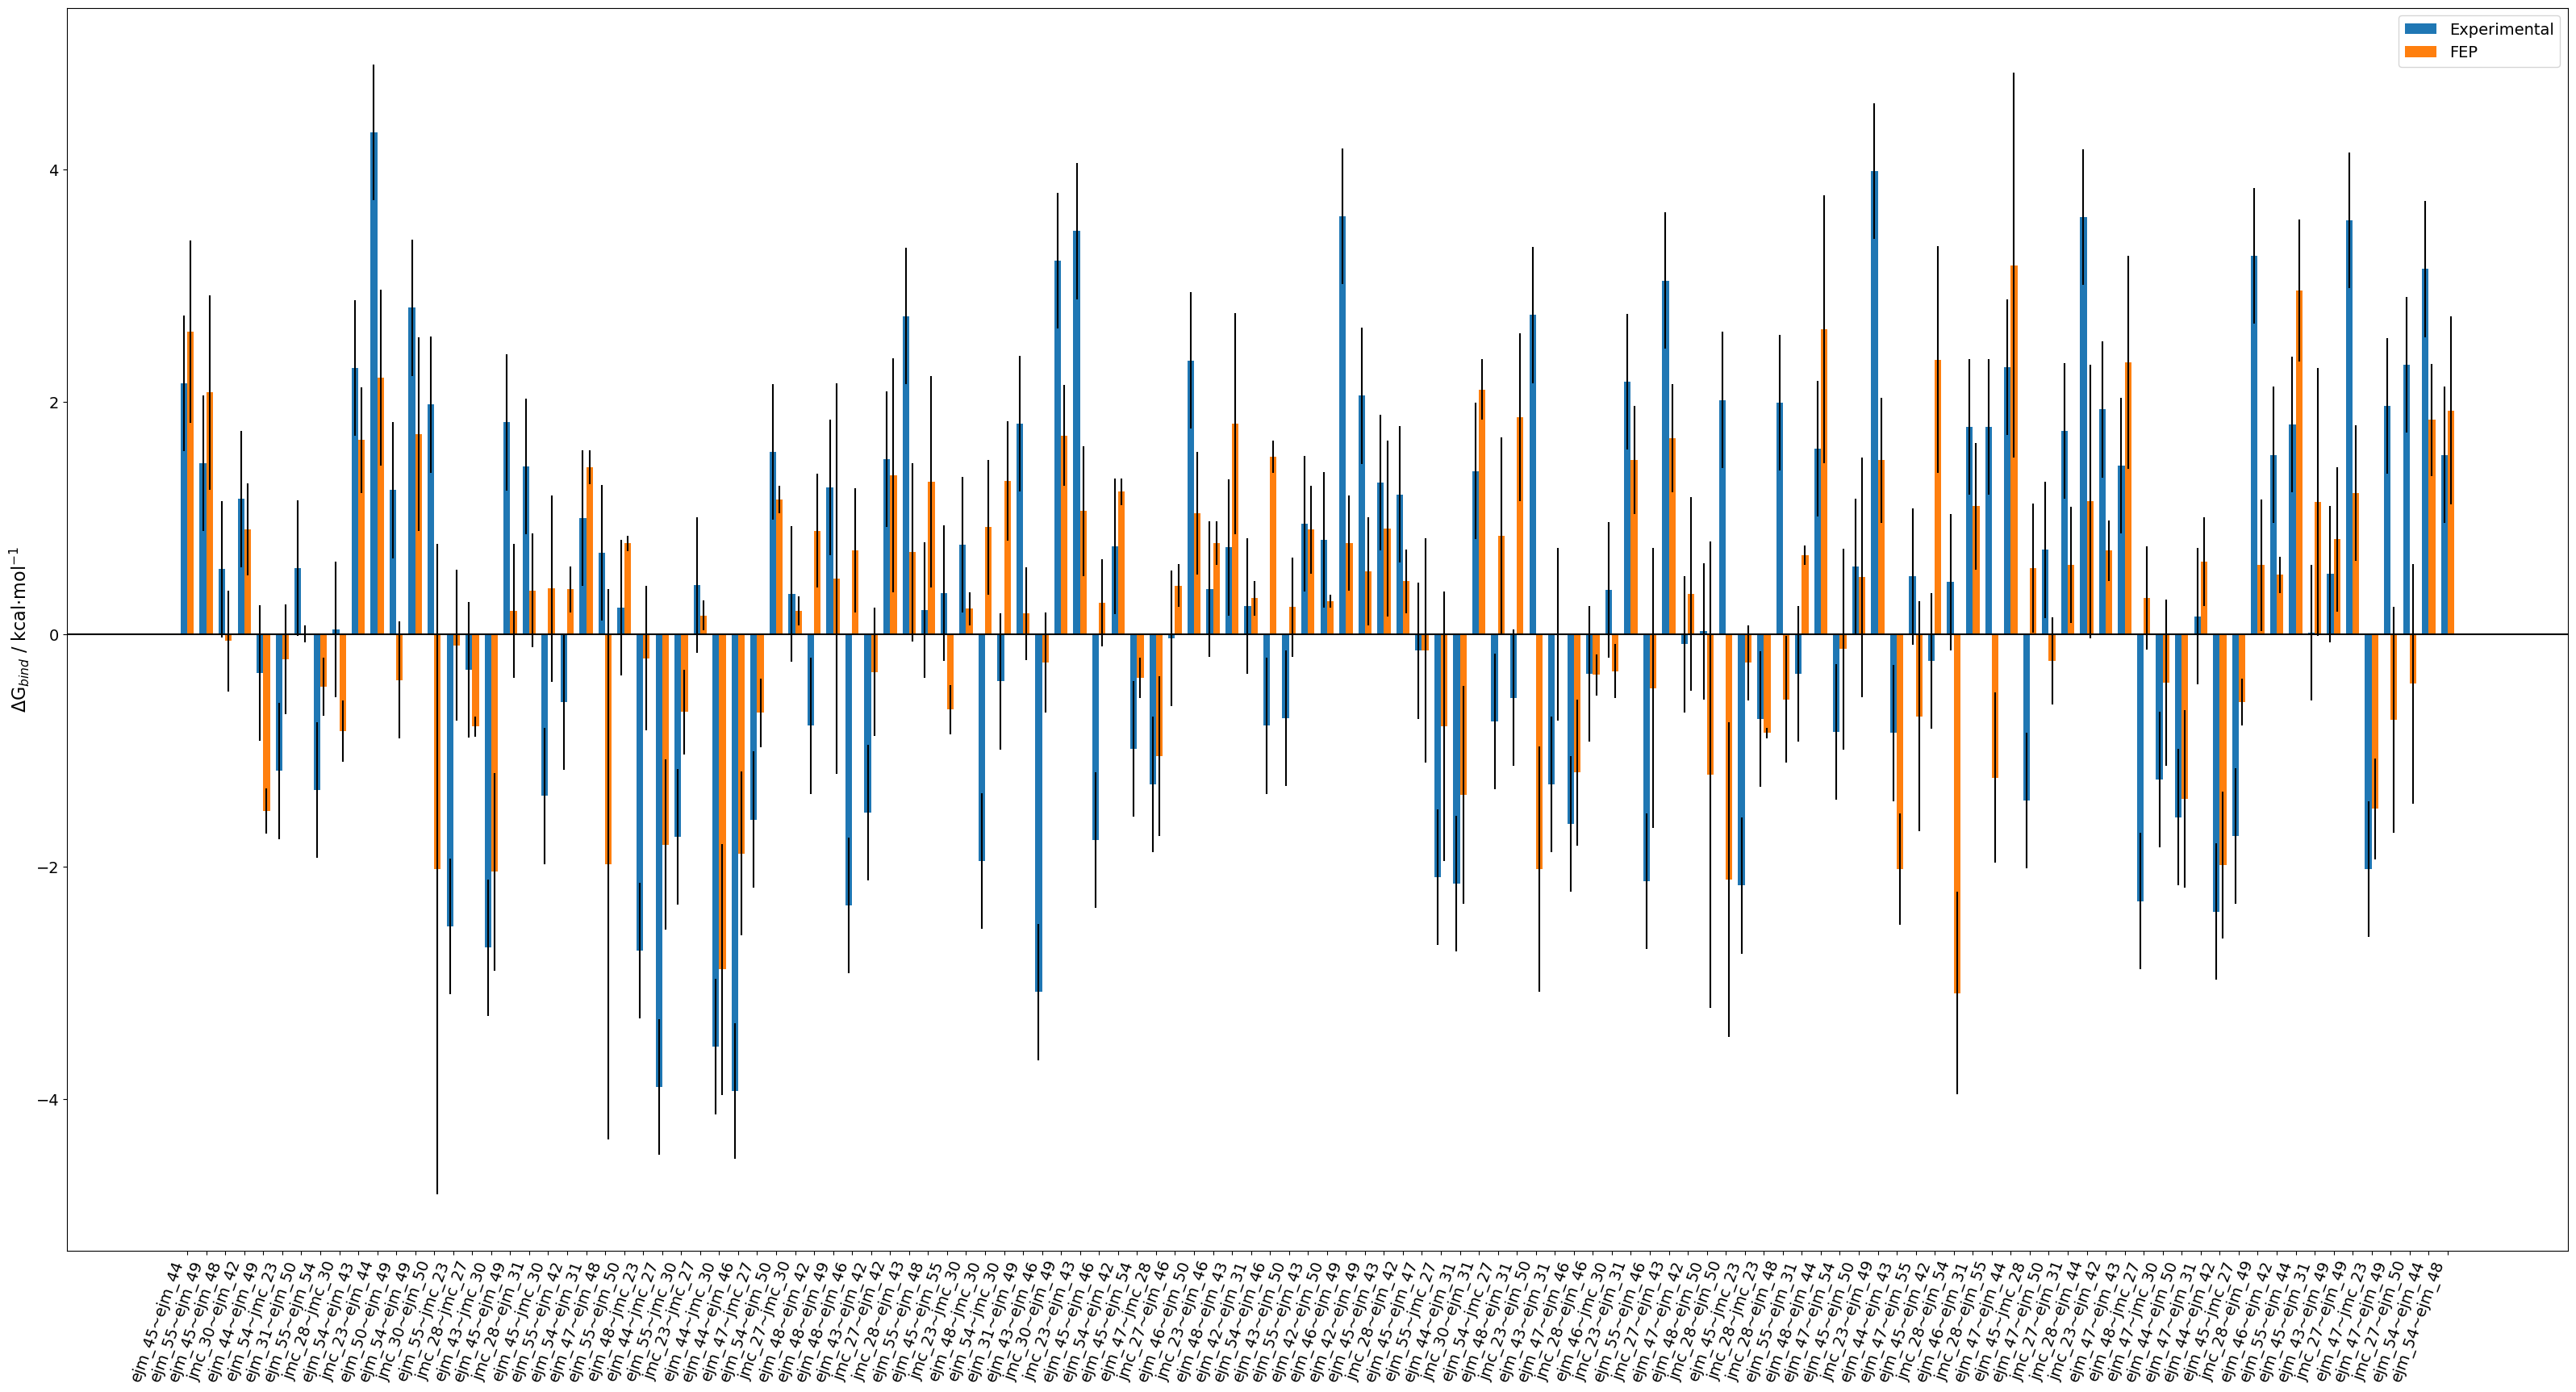

In [16]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(40,20))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

# plt.savefig("analysis/fep_vs_exp_diff_barplot.png", dpi=900)
plt.show()

As there is a lot of data, this plot is a bit crowded.

And then also as a scatterplot.

               freenrg_exp   err_exp  freenrg_fep   err_fep
ejm_45~ejm_44     2.156448  0.584392     2.603075  0.783510
ejm_55~ejm_49     1.469599  0.584392     2.078980  0.835742
ejm_45~ejm_48     0.558808  0.584392    -0.058300  0.435503
jmc_30~ejm_42     1.162877  0.584392     0.903880  0.396715
ejm_44~ejm_49    -0.333621  0.584392    -1.521250  0.192806
...                    ...       ...          ...       ...
ejm_47~jmc_23    -2.019660  0.584392    -1.502960  0.436456
ejm_47~ejm_49     1.965447  0.584392    -0.736500  0.974701
jmc_27~ejm_50     2.320391  0.584392    -0.427017  1.028530
ejm_54~ejm_44     3.141857  0.584392     1.844400  0.483151
ejm_54~ejm_48     1.544217  0.584392     1.925100  0.810828

[120 rows x 4 columns]


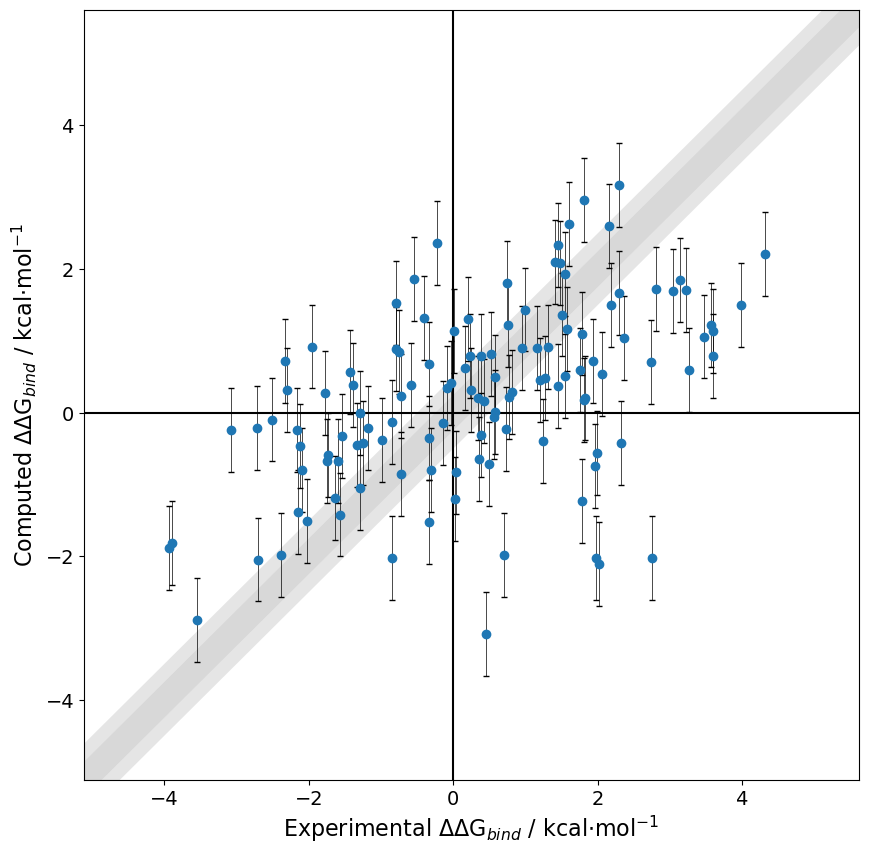

In [41]:
# plot a scatter plot
plt.rc('font', size=12)
fig, ax = plt.subplots(figsize=(10,10))

# get these based on which column the data is in.
x = freenrg_df["freenrg_exp"]
y = freenrg_df["freenrg_fep"]
y_er = freenrg_df["err_exp"]
x_er = freenrg_df["err_exp"]

# plotting the scatterplot
scatterplot = [plt.scatter(x, y, zorder=10)]

#plotting error bars
plt.errorbar(x , y,
            yerr=y_er,
            # xerr=x_er,   # comment this line to hide experimental error bars \
                        # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# plot 1/2 kcal bounds:
plt.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=-10,
                alpha=0.3,
                color="grey")
# upper bound:
plt.fill_between(
                x=[-100, 100], 
                y2=[-99.5,100.5],
                y1=[-99.75, 100.25],
                lw=0, 
                zorder=-10,
                color="grey", 
                alpha=0.2)
# lower bound:
plt.fill_between(
                x=[-100, 100], 
                y2=[-100.25,99.75],
                y1=[-100.5, 99.5],
                lw=0, 
                zorder=-10,
                color="grey", 
                alpha=0.2)

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)   
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)

plt.ylabel("Computed $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# plt.savefig("analysis/fep_vs_exp_scatterplot.png", dpi=300)
plt.show()

Extra - highlight any bad perturbations. Outlier annotation.

['jmc_23~ejm_50', 'jmc_28~ejm_50', 'jmc_30~ejm_50']


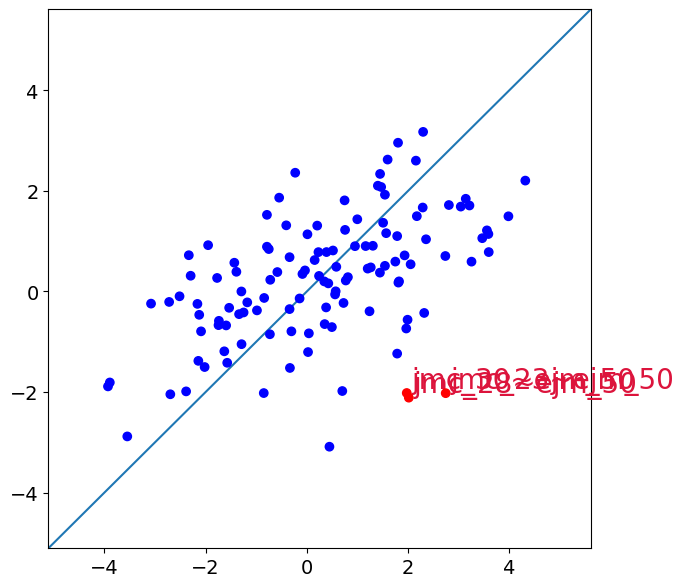

In [42]:
number_outliers_to_annotate = 3

# get an array of the MUE values comparing experimental and FEP values. Take the absolute values.
mue_values = abs(freenrg_df["freenrg_exp"] - freenrg_df["freenrg_fep"])

# find the n ligand names that are outliers.
outlier_names = mue_values.nlargest(number_outliers_to_annotate).index.values.tolist()
print(outlier_names)

# construct a list of labels to annotate the scatterplot with.
annot_labels = []
colours = []
for ligand in freenrg_df.index.values:
    # if the ligand is an outlier, append the name to the annotation labels list.
    if ligand in outlier_names:
        annot_labels.append(ligand)
        colours.append("red")
    else:
        # if the ligand is not an outlier, append an empty string to the annotation labels list.
        annot_labels.append("")
        colours.append("blue")

# Create the same scatterplot as above. Can include some more of the formatting if needed.
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10, c=colours)
plt.plot((-10,10),(-10,10))
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

# then, after generating the figure, we can annotate:
for i, txt in enumerate(annot_labels):
    plt.annotate(txt, 
                 (freenrg_df["freenrg_exp"].values.tolist()[i]+0.1,     # x coords
                  freenrg_df["freenrg_fep"].values.tolist()[i]+0.1),    # y coords
                 size=20, color="crimson")

plt.show()

### <span style="color:teal">2. Analysing per Ligand</span>
<a id="lig"></a>

#### <span style="color:teal">2.1. Freenrgworkflows</span>
<a id="fwf"></a>

We can also use [FreeNrgWorkFlows](https://github.com/michellab/freenrgworkflows) to analyse our predictions. Instead of just computing
ΔΔG values for each transformation, we would like to estimate the ΔΔG value for each individual ligand. There are some involved algorithms needed for these steps which is what FreeNrgWorkFlows takes care of for us.

If we have added any intermediate ligands, define the regular expression here. Ligands containing this pattern will be excluded from calculations that compare to experimental values. In this case, we don't have any.

In [44]:
intermediate_string = 'intermediate_01' # if you want to exclude an intermediate, just input as string.

Next, we will analyse our network using the `NetworkAnalyser()` and add all our data in. 

In [51]:
nA = networkanalysis.NetworkAnalyser()

first_file = False
for file_name in results_files:
    if first_file is False:
        nA.read_perturbations_pandas(file_name, comments='#')
        first_file = True
    else:
        # add more replicates to the graph. FreeNrgWorkflows will take care of averaging 
        # the free energies as well as propagating the error.
        nA.add_data_to_graph_pandas(file_name)


computed_relative_DDGs = nA.freeEnergyInKcal


Added additional data to 107 edges; added 2 new edges.
Added additional data to 108 edges; added 3 new edges.
Added additional data to 104 edges; added 2 new edges.
Added additional data to 108 edges; added 2 new edges.
Added additional data to 102 edges; added 2 new edges.


[{'ejm_31': 0.5670981788989665, 'error': 0.12092945086222119},
 {'ejm_42': 1.0259553629131952, 'error': 0.1214100893707075},
 {'ejm_43': 0.5845401412562629, 'error': 0.11132409185875784},
 {'ejm_44': 3.319254231507874, 'error': 0.15811108002140345},
 {'ejm_45': -0.6199109748747691, 'error': 0.12348997410462265},
 {'ejm_46': -1.9462567196190819, 'error': 0.223478943173265},
 {'ejm_47': -0.39021863537586987, 'error': 0.12515170086631322},
 {'ejm_48': 0.8537205328501061, 'error': 0.15556178946559082},
 {'ejm_49': -2.0120244704054926, 'error': 0.33616410508835404},
 {'ejm_50': -1.5823309400177583, 'error': 0.1495970313529871},
 {'ejm_54': -0.9795154705060336, 'error': 0.10976608932744823},
 {'ejm_55': -0.5283585082792162, 'error': 0.1039598032693248},
 {'jmc_23': 0.052734650262095006, 'error': 0.16253058355559571},
 {'jmc_27': -1.89360079495803, 'error': 0.21717888009955189},
 {'jmc_28': 2.2929617746416584, 'error': 0.25647796991617383},
 {'jmc_30': 1.2559516417060923, 'error': 0.236126145

After this, we can load in the experimental data. We already did this earlier using Freenrgworkflows as `experimental_ddGs`.

In [53]:
freenrg_dict = {}

# construct dict with experimental freenrg and error.
for item in experimental_DDGs:
    ligand = list(item.keys())[0]
    freenrg = list(item.values())[0]
    error = list(item.values())[1]
    freenrg_dict[ligand] = [freenrg, error]

# append computed freenrg and error.
for item in computed_relative_DDGs:
        ligand = list(item.keys())[0]
        freenrg = list(item.values())[0]
        error = list(item.values())[1]
        
        
        if intermediate_string not in ligand:
            freenrg_dict[ligand].append(freenrg)
            freenrg_dict[ligand].append(error)

freenrg_df = pd.DataFrame(freenrg_dict, index=["freenrg_exp", "err_exp", "freenrg_fep", "err_fep"]).transpose()

# save our results to a file that can be opened in e.g. Excel.
freenrg_df.to_csv("analysis/fep_results_table_per_ligand.csv")

#### <span style="color:teal">2.2. Plotting</span>
<a id="plot2"></a>

We can also plot a bar graph of the results using similar code to before.

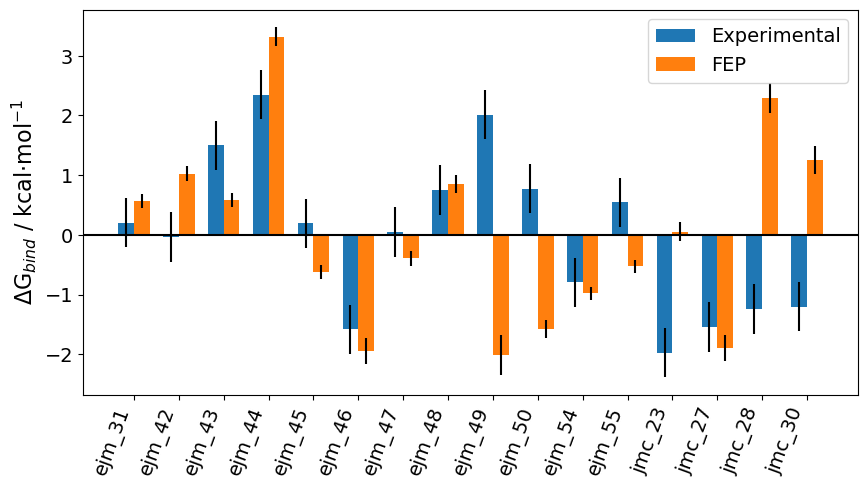

In [54]:
# initiate an empty figure with fixed dimensions.
fig, ax = plt.subplots(figsize=(10,5))

# determine positions for X axis labels.
x_locs = np.arange(len(freenrg_df))

# set bar width
width = 0.35  

# plot both our experimental and FEP free energies using an offset on the x position so bars don't overlap.
ax.bar(x_locs - width/2, height=freenrg_df["freenrg_exp"], width=width, yerr=freenrg_df["err_exp"],
                label='Experimental')
ax.bar(x_locs + width/2, height=freenrg_df["freenrg_fep"], width=width, yerr=freenrg_df["err_fep"],
                label='FEP')
 
# format the plot further.
plt.axhline(color="black")
plt.ylabel("$\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xticks(x_locs, freenrg_df.index, rotation=70, ha="right")
plt.legend()

# plt.savefig("analysis/fep_vs_exp_barplot_per_ligand.png", dpi=300)
plt.show()

and a scatterplot

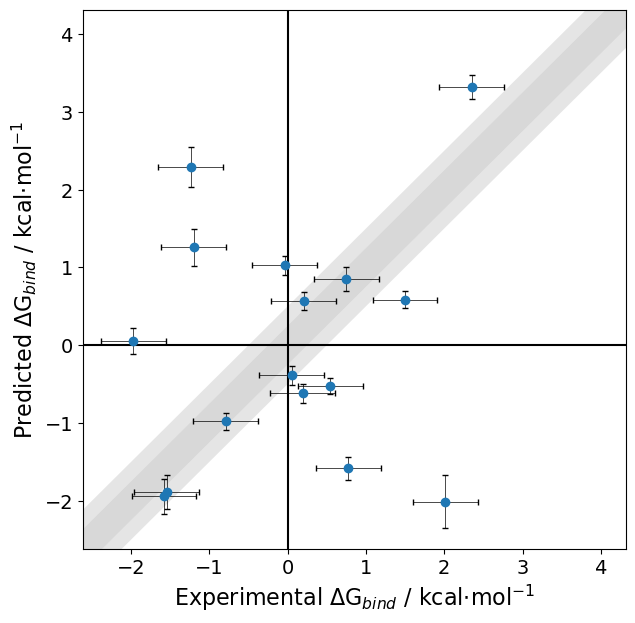

In [55]:
plt.figure(figsize=(7,7))

plt.scatter(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], zorder=10)

# plot 1/2 kcal bounds:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				alpha=0.3,
				color="grey")
# upper bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-99.5,100.5],
				y1=[-99.75, 100.25],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)
# lower bound:
plt.fill_between(
				x=[-100, 100], 
				y2=[-100.25,99.75],
				y1=[-100.5, 99.5],
				lw=0, 
				zorder=-10,
				color="grey", 
				alpha=0.2)

# plot error bars:
yerr = freenrg_df["err_fep"]
xerr = freenrg_df["err_exp"]

plt.errorbar(freenrg_df["freenrg_exp"], freenrg_df["freenrg_fep"], 
            yerr=yerr,
            xerr=xerr,   # comment this line to hide experimental error bars \
                         # as this can sometimes overcrowd the plot.
            ls="none",
            lw=0.5, 
            capsize=2,
            color="black",
            zorder=5
            )

# format the plot further.
plt.axhline(color="black", zorder=1)
plt.axvline(color="black", zorder=1)
plt.ylabel("Predicted $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")
plt.xlabel("Experimental $\Delta$G$_{bind}$ / kcal$\cdot$mol$^{-1}$")

# get the bounds. This can be done with min/max or simply by hand.
all_freenrg_values = np.concatenate([freenrg_df["freenrg_exp"].values,freenrg_df["freenrg_fep"].values])
min_lim = min(all_freenrg_values)
max_lim = max(all_freenrg_values)

# for a scatterplot we want the axis ranges to be the same. 
plt.xlim(min_lim*1.3, max_lim*1.3)
plt.ylim(min_lim*1.3, max_lim*1.3)

# plt.savefig("analysis/fep_vs_exp_scatterplot_per_ligand.png", dpi=300)
plt.show()

#### <span style="color:teal">2.3. Satistical analysis</span>
<a id="stats"></a>

Below are examples of how to re-sample from the data in order to obtain error bars on correlation coefficients, MUE and Kendall tau. Returned are confidence intervals of 65% and the median of the distribution. It is important to take these confidences into account as FEP predictions have a variance associated with them.

In [56]:
_stats = stats.freeEnergyStats()
_stats.generate_statistics(computed_relative_DDGs,experimental_DDGs,repeats=10000)
r_confidence = _stats.R_confidence
tau_confidence = _stats.tau_confidence
mue_confidence = _stats.mue_confidence
print ("R confidence is:   %.2f < %.2f < %.2f" %(r_confidence[1], r_confidence[0], r_confidence[2]))
print ("MUE confidence is: %.2f < %.2f < %.2f" %(mue_confidence[1], mue_confidence[0], mue_confidence[2]))
print ("Tau confidence is: %.2f < %.2f < %.2f" %(tau_confidence[1], tau_confidence[0], tau_confidence[2]))

R confidence is:   0.18 < 0.20 < 0.21
MUE confidence is: 1.30 < 1.32 < 1.34
Tau confidence is: 0.03 < 0.05 < 0.07


#### <span style="color:purple">Extra Exercise: </span> <span style="color:teal"> Visualising the ligand</span>

Based on our results, we may also want to visualise which of our ligands had the highest binding affinity.

Hint : First, sort the data frame to find the ligand with the best binding affinity and then use BSS to visualise it like in the introductionary workshop.

In [57]:
# answer 
results_table = pd.DataFrame(freenrg_df["freenrg_fep"]).sort_values(by="freenrg_fep")

# we can write the table to a csv file that can be opened in e.g. Excel.
# results_table.to_csv("analysis/fep_predictions.csv")

results_table

,freenrg_fep
ejm_49,-2.012024
ejm_46,-1.946257
jmc_27,-1.893601
ejm_50,-1.582331
ejm_54,-0.979515
ejm_45,-0.619911
ejm_55,-0.528359
ejm_47,-0.390219
jmc_23,0.052735
ejm_31,0.567098


In [59]:
# answer
BSS.Notebook.View("inputs/ligands/ejm49.sdf").system()

AttributeError: 'super' object has no attribute '_ipython_display_'

This notebook has covered the basics of some analysis that can be done on our RBFE results. There are many ways to customise this, and it is also a good idea to check out the <span style="color:pink">further reading </span>: 8.7 (For a good overview of FEP data reporting best practices) .
